In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
import glob
import json
import pickle
import os
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import proplot as pplt
import networkx as nx
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

COLORS = []
colors = pplt.Cycle('ggplot')
for color in colors:
    COLORS.append(color['color'])
colors = pplt.Cycle('default')
for color in colors:
    COLORS.append(color['color'])

COLORS[0], COLORS[1] = COLORS[1], COLORS[0]

    
pplt.rc['figure.facecolor'] = 'white'

RESULT_DIR = "/home/sj0161/mpcd_result/"
FIGURE_DIR = "/home/sj0161/mpcd_figure/"

with open('plot_style.json', 'r') as f:
    format_params = json.load(f)
    
MOMENTS    = np.array([0.1, 0.08, 0.06, 0.04, 0.030, 0.024, 0.018, 0.012, 
                    0.006, 0.003, 0.001, 0.0008, 0.0006, 0.0004])

def format_ax(ax):
    ax.format(**format_params)
    ax.tick_params(top=True, right=True, bottom=True, left=True, which='both')
    ax.minorticks_on()

In [3]:
import alphashape
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import umap

from cg_topo_solv.analysis.result import calc_viscosity, get_meta_counts, load_target, load_all_fit
from cg_topo_solv.bo.propose import check_bayesian_performance, target_value
from cg_topo_solv.ml.latent_sampling import latent_sampling
from cg_topo_solv.plot.plot_graph import plot_graph

from descartes import PolygonPatch
from matplotlib.ticker import NullLocator

from numpy.linalg import norm

from scipy.interpolate import splprep, splev
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import shortest_path
from scipy.stats import zscore

from shapely.geometry import Polygon

from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.neighbors import kneighbors_graph

from tqdm import tqdm

2025-08-04 16:01:13.647885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-04 16:01:15.688608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
sample, z_mean, y_all, c_all, graph_all = latent_sampling(
    seed=42, mode="maximin_sampling", rerun=False, size=30
)

hi_idx, mid_idx, lo_idx, target_curves, target_labels, target_params = load_target(RESULT_DIR, verbose=False)
all_descriptors, all_params, all_curves, shear_rates, all_graphs    = load_all_fit(RESULT_DIR, rerun=False)

base_path = "/home/sj0161/mpcd_result/"

csf_paths = [
    f"{base_path}/fit_visc_seed.pickle",
    f"{base_path}/fit_visc_csf_1.pickle",
    f"{base_path}/fit_visc_csf_2.pickle",
    f"{base_path}/fit_visc_csf_3.pickle",
    f"{base_path}/fit_visc_csf_4.pickle",
    f"{base_path}/fit_visc_csf_5.pickle",
]

sf_paths = [
    f"{base_path}/fit_visc_seed.pickle",
    f"{base_path}/fit_visc_sf_1.pickle",
    f"{base_path}/fit_visc_sf_2.pickle",
    f"{base_path}/fit_visc_sf_3.pickle",
    f"{base_path}/fit_visc_sf_4.pickle",
    f"{base_path}/fit_visc_sf_5.pickle",
]

al_paths = [
    f"{base_path}/fit_visc_seed.pickle",
    f"{base_path}/fit_visc_al_1.pickle",
    f"{base_path}/fit_visc_al_2.pickle",
    f"{base_path}/fit_visc_al_3.pickle",
    f"{base_path}/fit_visc_al_4.pickle",
    f"{base_path}/fit_visc_al_5.pickle",
]

results_csf   = {}
results_sf = {}
results_al  = {}

def process_paths(paths, results_dict):
    for mode in ["eta"]:
        all_ps = []
        all_eta = []
        min_dist = {k: {} for k in range(1, 6)}

        for batch_idx, path in tqdm(enumerate(paths), total=6):
            with open(path, "rb") as handle:
                xx, yy, topo, ps = (pickle.load(handle) for _ in range(4))

            all_ps.extend(ps)
            all_eta.extend(yy)

            y_train, y_target = target_value(
                params_fit=all_ps,
                params_target=target_params,
                eta_fit=all_eta,
                eta_target=target_curves,
                mode=mode,
            )

            for k in range(1, 6):
                dist = check_bayesian_performance(y_train, y_target, mode="mse", k=k)
                min_dist[k][batch_idx] = dist.mean(axis=1)

        results_dict[mode] = min_dist

process_paths(csf_paths,   results_csf)
process_paths(csf_paths, results_csf)
process_paths(al_paths,  results_al)

Loaded sampled latent space points from sample_z_mean_maximin_sampling.pickle


100%|██████████| 6/6 [00:17<00:00,  2.89s/it]


### active learning top-k results

0.10403292781417514
0.008504679912948078
0.0003946962835449111


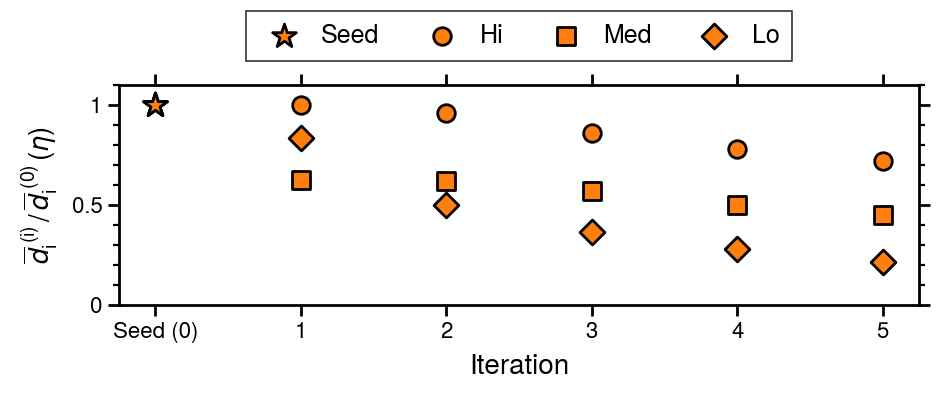

In [13]:
fig, ax = pplt.subplots(refwidth=4.0, refheight=1.1, ncols=1, nrows=1, sharey=False, sharex=False)

mode        = "eta"
xticks      = np.arange(6)
tick_ranges = [0, 10, 20, 30, 40, 50]
class_label = np.unique(c_all)
texts       = ["Hi", "Med", "Lo"]
groups      = [hi_idx, mid_idx, lo_idx]
markers     = ['o', 's', 'D']
cmap        = pplt.Colormap('browns6')
norm        = mcolors.Normalize(vmin=0.0, vmax=5.0)

for i, idx in enumerate(groups):
    raw = [[np.mean(results_al[mode][k][j][idx]) for j in range(6)] for k in range(1, 6)]
    raw = np.array(raw)

    curve = np.zeros((6, 6))
    curve[1:, :] = raw
    curve[0, :]  = raw[0, :]

    ax.scatter(
        xticks[0], 1.0,
        marker="*", s=80,
        facecolor=COLORS[8],
        edgecolor='k',
        label="Seed" if i == 0 else "",
        lw=1, zorder=3,
    )

    print(curve[0, 0])

    for j in range(1, 6):
        ax.scatter(
            xticks[j], curve[j, j] / curve[j, 0],
            marker=markers[i], s=40,
            facecolor=COLORS[8],
            edgecolor='k',
            label=texts[i] if j == 1 else "",
            lw=1, zorder=3,
        )

format_ax(ax)

ax.legend(
    loc="t",
    prop={"size": 9},
    ncol=4,
)

ax.format(
    xlabel="Iteration",
    ylabel=r"$\overline{\mathit{d}}_{i}^{~(i)}\,/\,\overline{\mathit{d}}_{i}^{~(0)}\,(\mathit{\eta})$",
    xticks=xticks,
    xticklabels=["Seed (0)"] + [str(i) for i in range(1, 6)],
    ylim=(0.0, 1.1),
)

ax.xaxis.set_minor_locator(NullLocator())

### comparison with other search methods: space-filling and class-balanced space-filling

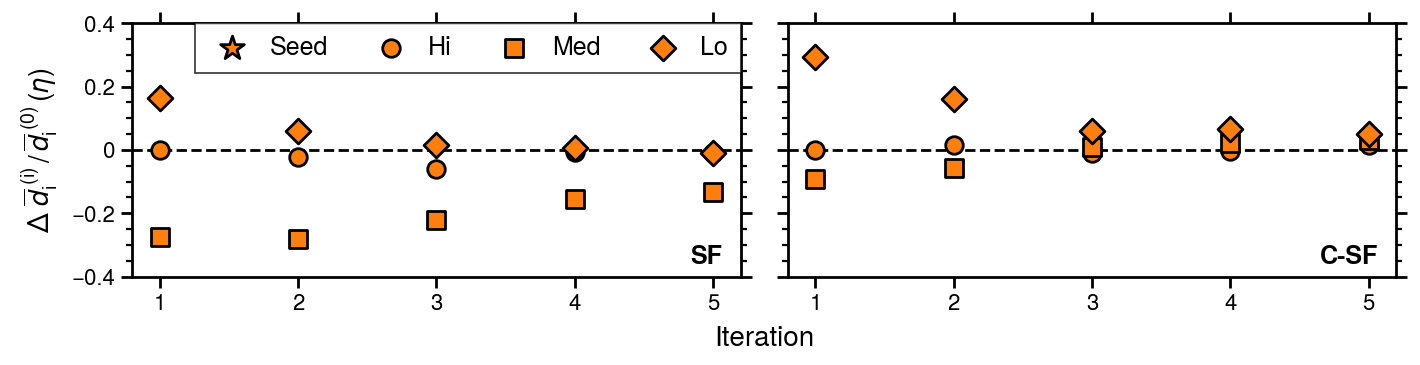

In [21]:
fig, ax = pplt.subplots(figsize=(7.1, None), ncols=2, nrows=1, refaspect=2.4, sharey=True, sharex=True)

mode       = "eta"
xticks     = np.arange(1, 6)
texts      = ["Hi", "Mid", "Lo"]
groups     = [hi_idx, mid_idx, lo_idx]
markers    = ['o', 's', 'D']
cmap       = pplt.Colormap('browns6')
norm       = mcolors.Normalize(vmin=0.0, vmax=5.0)

for i, idx in enumerate(groups):
    raw_al = [[np.mean(results_al[mode][k][j][idx]) for j in range(6)] for k in range(1, 6)]
    raw_csf = [[np.mean(results_csf[mode][k][j][idx]) for j in range(6)] for k in range(1, 6)]
    raw_sf = [[np.mean(results_sf[mode][k][j][idx]) for j in range(6)] for k in range(1, 6)]

    data_al = np.zeros((6, 6))
    data_csf = np.zeros((6, 6))
    data_sf = np.zeros((6, 6))

    data_al[1:]     = raw_al
    data_csf[1:]   = raw_csf
    data_sf[1:] = raw_sf

    data_al[0]     = raw_al[0]
    data_csf[0]   = raw_csf[0]
    data_sf[0] = raw_sf[0]


    for j in range(1, 6):
        delta_sf = data_al[j][j] / data_al[j][0] - data_sf[j][j] / data_sf[j][0]
        delta_csf   = data_al[j][j] / data_al[j][0] - data_csf[j][j] / data_csf[j][0]

        ax[0].scatter(
            xticks[j-1], delta_sf,
            marker=markers[i], s=40,
            facecolor=COLORS[8], edgecolor='k',
            lw=1, zorder=3,
        )

        ax[1].scatter(
            xticks[j-1], delta_csf,
            marker=markers[i], s=40,
            facecolor=COLORS[8], edgecolor='k',
            lw=1, zorder=3,
        )

ax[0].axhline(0, color='k', linestyle='--', lw=1, zorder=1)
ax[1].axhline(0, color='k', linestyle='--', lw=1, zorder=1)

for i in range(2):
    format_ax(ax[i])

    if i == 0:
        handle_seed = ax[i].scatter([], [], facecolors=COLORS[8], edgecolors='k', s=80, marker="*", label="Seed", lw=1)
        handle_hi   = ax[i].scatter([], [], facecolors=COLORS[8], edgecolors='k', s=40, marker=markers[0], label="Hi", lw=1)
        handle_mid  = ax[i].scatter([], [], facecolors=COLORS[8], edgecolors='k', s=40, marker=markers[1], label="Med", lw=1)
        handle_lo   = ax[i].scatter([], [], facecolors=COLORS[8], edgecolors='k', s=40, marker=markers[2], label="Lo", lw=1)
        ax[i].legend(
            handles=[handle_seed, handle_hi, handle_mid, handle_lo],
            loc="upper right", prop={"size": 9}, ncol=4,
        )

    ax[i].format(
        xlabel="Iteration",
        ylabel=r"$\Delta ~ \overline{\mathit{d}}_{i}^{~(i)}\,/\,\overline{\mathit{d}}_{i}^{~(0)}\,(\mathit{\eta})$",
        xticks=xticks,
        xticklabels=[str(j) for j in range(1, 6)],
        ylim=(-0.4, 0.4),
    )
    ax[i].xaxis.set_minor_locator(NullLocator())

ax[0].text(0.97, 0.03, "SF",    ha='right', va='bottom', transform=ax[0].transAxes, size=9, weight="bold")
ax[1].text(0.97, 0.03, "C-SF",  ha='right', va='bottom', transform=ax[1].transAxes, size=9, weight="bold")

### active learning latent space exploration

In [5]:
def load_z_vectors(paths, extra_loads=2):
    z_list = []
    for path in paths:
        with open(path, "rb") as f:
            for _ in range(extra_loads):
                pickle.load(f)
            z = pickle.load(f)
        z_list.append(np.array(z))
    return np.concatenate(z_list, axis=0)

sample, z_mean, y_all, c_all, graph_all = latent_sampling(
    seed=42, mode="maximin_sampling", rerun=False, size=30
)
z_selected = z_mean[sample[:30]]

csf_paths = [f"{RESULT_DIR}/batch{i}_sample_csf.pickle" for i in range(1, 6)]
z_csf = np.concatenate([z_selected, load_z_vectors(csf_paths)], axis=0)

sf_paths = [f"{RESULT_DIR}/batch{i}_sample_sf.pickle" for i in range(1, 6)]
z_sf = np.concatenate([z_selected, load_z_vectors(sf_paths)], axis=0)

al_paths = [f"{RESULT_DIR}/batch{i}_sample_al.pickle" for i in range(1, 6)]
z_al = np.concatenate([z_selected, load_z_vectors(al_paths, extra_loads=3)], axis=0)

Loaded sampled latent space points from sample_z_mean_maximin_sampling.pickle


In [6]:
umap_dim = 3
n_neighbors = 200
min_dist = 0.6

file_path = os.path.join(RESULT_DIR, f"umap_{umap_dim}d_{n_neighbors}_{min_dist}.pickle")

if os.path.exists(file_path):
    with open(file_path, "rb") as handle:
        mus_2d = pickle.load(handle)
        mus_2d_subset = pickle.load(handle)
        umap_reducer = pickle.load(handle)
else:
    umap_reducer = umap.UMAP(
        n_components=umap_dim,
        random_state=42,
        n_neighbors=n_neighbors,
        min_dist=min_dist
    )
    umap_reducer.fit(z_mean[:])
    mus_2d = umap_reducer.transform(z_mean)
    mus_2d_subset = umap_reducer.transform(z_mean[sample])

    with open(file_path, "wb") as handle:
        pickle.dump(mus_2d, handle)
        pickle.dump(mus_2d_subset, handle)
        pickle.dump(umap_reducer, handle)

mus_mean = mus_2d.mean(axis=0)
mus_2d_subset = mus_2d_subset - mus_mean
mus_2d = mus_2d - mus_mean

mus_csf = umap_reducer.transform(z_csf) - mus_mean
mus_sf = umap_reducer.transform(z_sf) - mus_mean
mus_al = umap_reducer.transform(z_al) - mus_mean

In [8]:
idx_hi, idx_mid, idx_lo, curves, samples_y, params = load_target(RESULT_DIR)

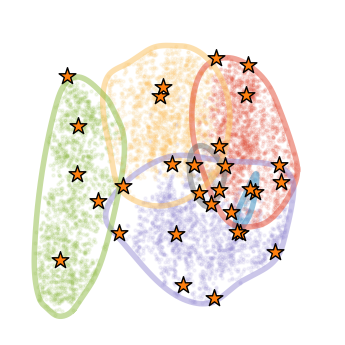

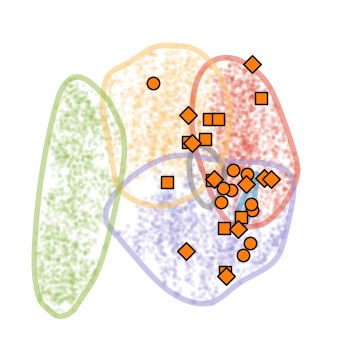

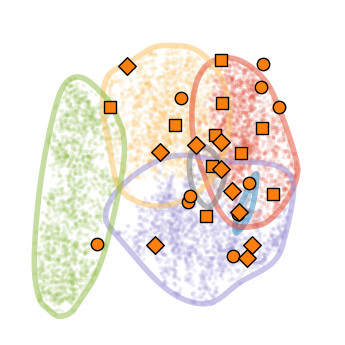

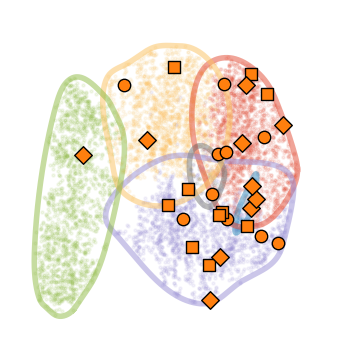

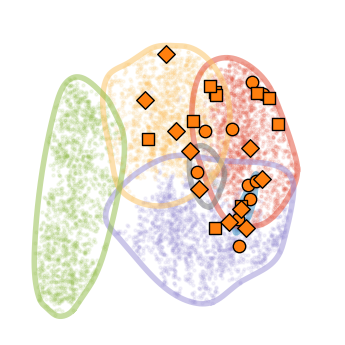

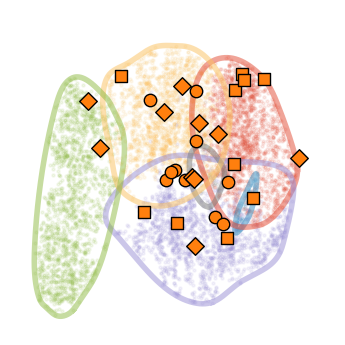

In [9]:
class_labels = ["linear", "comb", "branch", "cyclic", "star", "dendrimer"]

for i in range(6):
    fig, ax = pplt.subplots(refwidth=1.6, refheight=1.6)
    
    for index, label in enumerate(class_labels):
        color = COLORS[index % len(COLORS)]
        mask = c_all == label
        x_temp = mus_2d[mask, 0]
        y_temp = mus_2d[mask, 2]
        ax.scatter(x_temp, y_temp, color=color, s=1, alpha=0.1)
        
        coords = np.stack((x_temp, y_temp), axis=1)
        zscores = np.abs(zscore(coords, axis=0))
        if label == "branch":
            filtered = coords[(zscores < 2.5).all(axis=1)]
        else:
            filtered = coords[(zscores < np.inf).all(axis=1)]
    
        alpha_shape = alphashape.alphashape(filtered, .001)
        if alpha_shape.geom_type == 'Polygon':
            boundary = np.array(alpha_shape.exterior.coords)
            x, y = boundary[:, 0], boundary[:, 1]
            tck, u = splprep([x, y], s=.001, per=True)
            smooth = splev(np.linspace(0, 1, 1000), tck)
            smooth_boundary = np.vstack(smooth).T
            ax.plot(smooth_boundary[:, 0], smooth_boundary[:, 1], color=color, linewidth=2, alpha=0.5)


    cmap = pplt.Colormap('browns6')
    norm = mcolors.Normalize(vmin=0.0, vmax=5.0)

    color = cmap(norm(i))

    markers = ['o', 's', 'D']

    ax.scatter(
        mus_al[idx_hi+i*30, 0],
        mus_al[idx_hi+i*30, 2],
        facecolor=COLORS[8],
        edgecolor="k",
        marker="*" if i == 0 else 'o',
        linewidth=0.5,
        s=40 if i == 0 else 20,
        alpha=1,
        zorder=4,
    )

    ax.scatter(
        mus_al[idx_mid+i*30, 0],
        mus_al[idx_mid+i*30, 2],
        facecolor=COLORS[8],
        edgecolor="k",
        marker="*" if i == 0 else 's',
        linewidth=0.5,
        s=40 if i == 0 else 20,
        alpha=1,
        zorder=4,
    )

    ax.scatter(
        mus_al[idx_lo+i*30, 0],
        mus_al[idx_lo+i*30, 2],
        facecolor=COLORS[8],
        edgecolor="k",
        marker="*" if i == 0 else 'D',
        linewidth=0.5,
        s=40 if i == 0 else 20,
        alpha=1,
        zorder=4,
    )
    
    format_ax(ax)
    ax.format(
        xlim=[-6, 6],
        ylim=[-4, 4],
    )
    ax.axis("off")
    
    fig.save(f"{FIGURE_DIR}/fig2-active_learning_result_umap_al_{i}_v2.png", dpi=600, transparent=True, bbox_inches="tight")

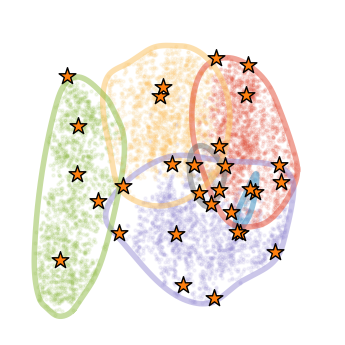

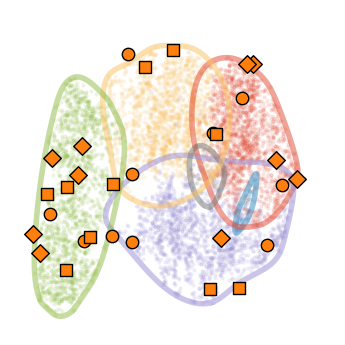

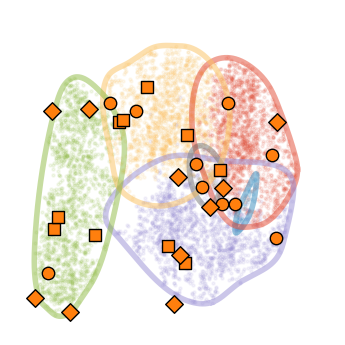

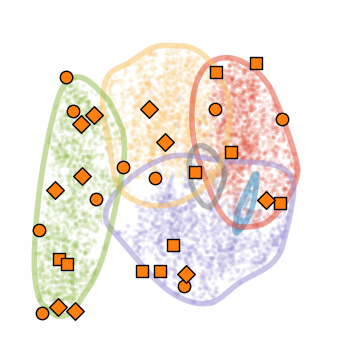

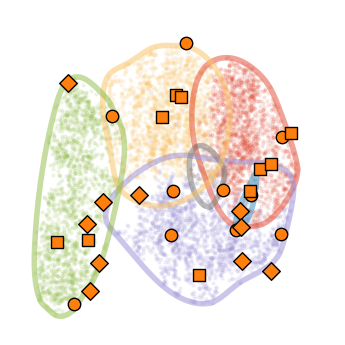

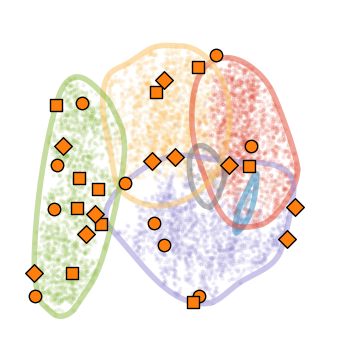

In [10]:
class_labels = ["linear", "comb", "branch", "cyclic", "star", "dendrimer"]

for i in range(6):
    fig, ax = pplt.subplots(refwidth=1.6, refheight=1.6)
    
    for index, label in enumerate(class_labels):
        color = COLORS[index % len(COLORS)]
        mask = c_all == label
        x_temp = mus_2d[mask, 0]
        y_temp = mus_2d[mask, 2]
        ax.scatter(x_temp, y_temp, color=color, s=1, alpha=0.1)
        
        coords = np.stack((x_temp, y_temp), axis=1)
        zscores = np.abs(zscore(coords, axis=0))
        if label == "branch":
            filtered = coords[(zscores < 2.5).all(axis=1)]
        else:
            filtered = coords[(zscores < np.inf).all(axis=1)]
    
        alpha_shape = alphashape.alphashape(filtered, .001)
        if alpha_shape.geom_type == 'Polygon':
            boundary = np.array(alpha_shape.exterior.coords)
            x, y = boundary[:, 0], boundary[:, 1]
            tck, u = splprep([x, y], s=.001, per=True)
            smooth = splev(np.linspace(0, 1, 1000), tck)
            smooth_boundary = np.vstack(smooth).T
            ax.plot(smooth_boundary[:, 0], smooth_boundary[:, 1], color=color, linewidth=2, alpha=0.5)


    cmap = pplt.Colormap('browns6')
    norm = mcolors.Normalize(vmin=0.0, vmax=5.0)

    color = cmap(norm(i))

    markers = ['o', 's', 'D']

    ax.scatter(
        mus_sf[idx_hi+i*30, 0],
        mus_sf[idx_hi+i*30, 2],
        facecolor=COLORS[8],
        edgecolor="k",
        marker="*" if i == 0 else 'o',
        linewidth=0.5,
        s=40 if i == 0 else 20,
        alpha=1,
        zorder=4,
    )

    ax.scatter(
        mus_sf[idx_mid+i*30, 0],
        mus_sf[idx_mid+i*30, 2],
        facecolor=COLORS[8],
        edgecolor="k",
        marker="*" if i == 0 else 's',
        linewidth=0.5,
        s=40 if i == 0 else 20,
        alpha=1,
        zorder=4,
    )

    ax.scatter(
        mus_sf[idx_lo+i*30, 0],
        mus_sf[idx_lo+i*30, 2],
        facecolor=COLORS[8],
        edgecolor="k",
        marker="*" if i == 0 else 'D',
        linewidth=0.5,
        s=40 if i == 0 else 20,
        alpha=1,
        zorder=4,
    )
    
    format_ax(ax)
    ax.format(
        xlim=[-6, 6],
        ylim=[-4, 4],
    )
    ax.axis("off")
    
    fig.save(f"{FIGURE_DIR}/fig2-active_learning_result_umap_sf_{i}_v2.png", dpi=600, transparent=True, bbox_inches="tight")

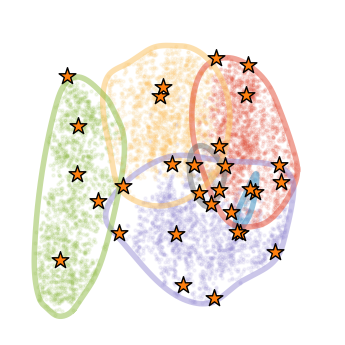

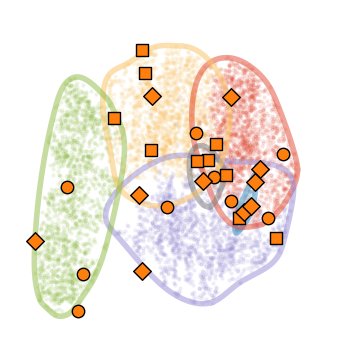

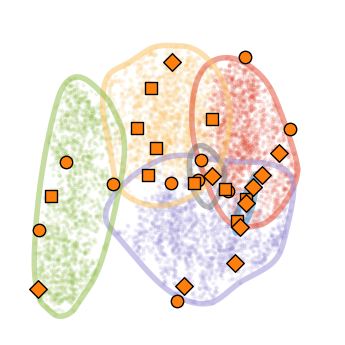

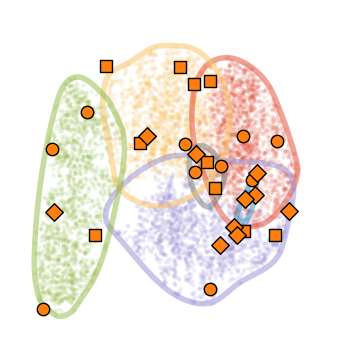

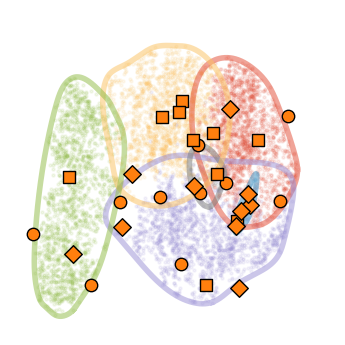

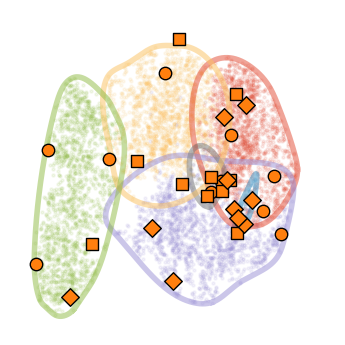

In [11]:
class_labels = ["linear", "comb", "branch", "cyclic", "star", "dendrimer"]

for i in range(6):
    fig, ax = pplt.subplots(refwidth=1.6, refheight=1.6)
    
    for index, label in enumerate(class_labels):
        color = COLORS[index % len(COLORS)]
        mask = c_all == label
        x_temp = mus_2d[mask, 0]
        y_temp = mus_2d[mask, 2]
        ax.scatter(x_temp, y_temp, color=color, s=1, alpha=0.1)
        
        coords = np.stack((x_temp, y_temp), axis=1)
        zscores = np.abs(zscore(coords, axis=0))
        if label == "branch":
            filtered = coords[(zscores < 2.5).all(axis=1)]
        else:
            filtered = coords[(zscores < np.inf).all(axis=1)]
    
        alpha_shape = alphashape.alphashape(filtered, .001)
        if alpha_shape.geom_type == 'Polygon':
            boundary = np.array(alpha_shape.exterior.coords)
            x, y = boundary[:, 0], boundary[:, 1]
            tck, u = splprep([x, y], s=.001, per=True)
            smooth = splev(np.linspace(0, 1, 1000), tck)
            smooth_boundary = np.vstack(smooth).T
            ax.plot(smooth_boundary[:, 0], smooth_boundary[:, 1], color=color, linewidth=2, alpha=0.5)


    cmap = pplt.Colormap('browns6')
    norm = mcolors.Normalize(vmin=0.0, vmax=5.0)

    color = cmap(norm(i))

    markers = ['o', 's', 'D']

    ax.scatter(
        mus_csf[idx_hi+i*30, 0],
        mus_csf[idx_hi+i*30, 2],
        facecolor=COLORS[8],
        edgecolor="k",
        marker="*" if i == 0 else 'o',
        linewidth=0.5,
        s=40 if i == 0 else 20,
        alpha=1,
        zorder=4,
    )

    ax.scatter(
        mus_csf[idx_mid+i*30, 0],
        mus_csf[idx_mid+i*30, 2],
        facecolor=COLORS[8],
        edgecolor="k",
        marker="*" if i == 0 else 's',
        linewidth=0.5,
        s=40 if i == 0 else 20,
        alpha=1,
        zorder=4,
    )

    ax.scatter(
        mus_csf[idx_lo+i*30, 0],
        mus_csf[idx_lo+i*30, 2],
        facecolor=COLORS[8],
        edgecolor="k",
        marker="*" if i == 0 else 'D',
        linewidth=0.5,
        s=40 if i == 0 else 20,
        alpha=1,
        zorder=4,
    )
    
    format_ax(ax)
    ax.format(
        xlim=[-6, 6],
        ylim=[-4, 4],
    )
    ax.axis("off")
    
    fig.save(f"{FIGURE_DIR}/fig2-active_learning_result_umap_csf_{i}_v2.png", dpi=600, transparent=True, bbox_inches="tight")